In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/analysisTools")
import plotTools as ptools

In [2]:
f_sig = "signal_v2_2018_aEM_ejdR_rejection_IDcut.coffea"
sig = util.load(f_sig)[0]

bkg_files = {
    "QCD":"bkg_2018_QCD_TuneCP5_PSWeights_ejdR_rejection_IDcut.coffea",
    "Top":"bkg_2018_Top_ejdR_rejection_IDcut.coffea",
    "DY":"bkg_2018_DY_ejdR_rejection_IDcut.coffea",
    "Diboson":"bkg_2018_Diboson_ejdR_rejection_IDcut.coffea",
    "Triboson":"bkg_2018_Triboson_ejdR_rejection_IDcut.coffea",
    "W+jets":"bkg_2018_WJets_ejdR_rejection_IDcut.coffea",
    "Z+jets":"bkg_2018_ZJets_ejdR_rejection_IDcut.coffea"
}
bkg_histos = {}
for b in bkg_files.keys():
    bkg_histos[b] = util.load(bkg_files[b])[0]
    histograms = list(bkg_histos[b].keys())
all_bkgs = list(bkg_histos.keys())
bkg = {}
for h in histograms:
    if type(bkg_histos['Top'][h]) != hist.Hist:
        continue
    hists = []
    for b in all_bkgs:
        hists.append(bkg_histos[b][h])
    bkg[h] = sum(hists)[{"samp":sum}]

In [3]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

In [4]:
from matplotlib.colors import LogNorm
def plot(samp,hname,rebinx,rebiny,xlim,ylim,cut=None):
    ctaus = [1,10,100]
    for ct in ctaus:
        hs = sig[hname][{"samp":f"{samp}_ctau-{ct}","cut":cut}][::rebinx,::rebiny]
        hb = sum([bkg[hname][k] for k in bkg[hname].keys()])[{"cut":cut}][::rebinx,::rebiny]
        vmin = min(hs.values()[hs.values()>0].min(),hb.values()[hb.values()>0].min())
        vmax = max(hs.values()[hs.values()>0].max(),hb.values()[hb.values()>0].max())
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        hs.plot2d(norm=LogNorm(vmin=vmin,vmax=vmax),cmap='plasma')
        #cb = plt.gca().images[-1].colorbar
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.subplot(122)
        hb.plot2d(norm=LogNorm(vmin=vmin,vmax=vmax),cmap='plasma')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.tight_layout()

In [5]:
from matplotlib.colors import LogNorm
def plotbkg(samp,hname,rebinx,rebiny,xlim,ylim,cut=None):
    hb = sum([bkg[hname][k] for k in bkg[hname].keys()])[{"cut":cut}][::rebinx,::rebiny]
    vmin = hb.values()[hb.values()>0].min()
    vmax = hb.values()[hb.values()>0].max()
    plt.figure(figsize=(5,5))
    hb.plot2d(norm=LogNorm(vmin=vmin,vmax=vmax),cmap='plasma')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()

In [4]:
from matplotlib.colors import LogNorm
def plot_SoverB(samp,hname,rebinx,rebiny,cut="cut7",forwardX=True,forwardY=True,xlabel="",ylabel="",m="",dm="",ct="",xlim=None,ylim=None):
    hb = bkg[hname][{"cut":cut}][::rebinx,::rebiny]
    x = hb.axes[0].edges[:-1]
    y = hb.axes[1].edges[:-1]
    ratios = {}
    hs = sig[hname][{"samp":samp,"cut":cut}][::rebinx,::rebiny]
    num = np.zeros((len(x),len(y)))
    den = np.zeros((len(x),len(y)))
    for i,xi in enumerate(x):
        for j,yj in enumerate(y):
            sliceX = slice(i,hist.overflow+1,sum) if forwardX else slice(hist.underflow,i+1,sum)
            sliceY = slice(j,hist.overflow+1,sum) if forwardY else slice(hist.underflow,j+1,sum)
            num[i,j] = hs[sliceX,sliceY].value
            den[i,j] = hb[sliceX,sliceY].value
    ratio = np.divide(num,np.sqrt(den),where=den>0)
    ratio[(num>0)&(den==0)] = np.inf
    ratio[(num==0)&(den==0)] = 0
    vmax = np.max(ratio[ratio!=np.inf])
    vmin = np.min(ratio[ratio>0])
    
    plt.figure(figsize=(5,5))
    from matplotlib.colors import LogNorm
    norm = LogNorm(vmin=vmin,vmax=vmax)
    ratio[ratio==np.inf] = vmax
    plt.imshow(ratio.T,extent=[x[0],x[-1],y[0],y[-1]],aspect='auto',origin='lower',norm=norm,cmap='plasma')
    xlabel_mod = xlabel+", forward" if forwardX else xlabel+", backward"
    ylabel_mod = ylabel+", forward" if forwardY else ylabel+", backward"
    plt.xlabel(xlabel_mod,fontsize=14)
    plt.ylabel(ylabel_mod,fontsize=14)
    plt.colorbar()
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.title(r"$\Delta$ = {0:.1f}, $m$ = {1}, $c\tau$ = {2}".format(dm,int(m),int(ct)),fontsize=16)
    plt.tight_layout()
    if not os.path.exists(f"plots/ABCD/{cut}/{hname}/{samp}"):
        os.makedirs(f"plots/ABCD/{cut}/{hname}/{samp}")
    xtitle = "forwardX" if forwardX else "backwardX"
    ytitle = "forwardY" if forwardY else "backwardY"
    plt.savefig(f"plots/ABCD/{cut}/{hname}/{samp}/significance_{samp}_{xtitle}_{ytitle}.png")
    plt.close()
    
    plt.figure(figsize=(5,5))
    hs.plot2d(ax=plt.gca(),norm=LogNorm())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    #plt.colorbar()
    plt.title(r"$\Delta$ = {0:.1f}, $m$ = {1}, $c\tau$ = {2}".format(dm,int(m),int(ct)),fontsize=16)
    plt.savefig(f"plots/ABCD/{cut}/{hname}/{samp}/{samp}.png")
    plt.close()
    
    plt.figure(figsize=(5,5))
    hb.plot2d(ax=plt.gca(),norm=LogNorm())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    #plt.colorbar()
    plt.title("Combined Backgrounds")
    plt.savefig(f"plots/ABCD/{cut}/{hname}/backgrounds.png")
    plt.close()

In [5]:
def runPlots(hname,rebinx,rebiny,cut,forwardX,forwardY,xlabel,ylabel,xlim=None,ylim=None):
    from tqdm import tqdm
    for delta in deltas:
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for m1 in tqdm(m1s):
            ctaus = sorted(list(set(si[(si.delta==delta)&(si.m1==m1)].ctau)))
            for ct in ctaus:
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                
                plot_SoverB(point,hname,rebinx,rebiny,
                            cut=cut,forwardX=forwardX,forwardY=forwardY,
                            m=m1,dm=delta,ct=ct,xlabel=xlabel,ylabel=ylabel,
                           xlim=xlim,ylim=ylim)

# Plots at cut 7 : $\chi^2 < 3$

In [12]:
runPlots("sel_vtx_maxPFIso_vs_mindxy",1j,1j,cut='cut7',forwardX=False,forwardY=True,
         xlabel="$I_\mathrm{PF}^\mathrm{rel}$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2.5])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


In [15]:
runPlots("sel_vtx_METdPhi_vs_mindxy",1j,1j,cut='cut7',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        xlim=[0,1],ylim=[0,2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


In [17]:
runPlots("sel_vtx_METdPhi_vs_vxy",1j,1j,cut='cut7',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$v_{xy}$",
        xlim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


In [19]:
runPlots("sel_vtx_mindRj_vs_mindxy",1j,1j,cut='cut7',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


In [21]:
runPlots("sel_vtx_mindPhiJ_vs_mindxy",1j,1j,cut='cut7',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


In [23]:
runPlots("sel_vtx_mindRj_vs_maxPFIso",1j,1j,cut='cut7',forwardX=True,forwardY=False,
            xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
           ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


In [24]:
runPlots("sel_vtx_mindPhiJ_vs_maxPFIso",1j,1j,cut='cut7',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


In [25]:
runPlots("sel_vtx_minEledRj_vs_mindxy",1j,1j,cut='cut7',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


In [26]:
runPlots("sel_vtx_minEledPhiJ_vs_mindxy",1j,1j,cut='cut7',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


In [27]:
runPlots("sel_vtx_minEledRj_vs_maxPFIso",1j,1j,cut='cut7',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


In [28]:
runPlots("sel_vtx_minEledPhiJ_vs_maxPFIso",1j,1j,cut='cut7',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


# Plots at cut 8 : $\Delta\phi(e^+e^-,p_T^\mathrm{miss}) < 1.0$

In [29]:
runPlots("sel_vtx_maxPFIso_vs_mindxy",1j,1j,cut='cut8',forwardX=False,forwardY=True,
         xlabel="$I_\mathrm{PF}^\mathrm{rel}$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2.5])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]


In [30]:
runPlots("sel_vtx_METdPhi_vs_mindxy",1j,1j,cut='cut8',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        xlim=[0,1],ylim=[0,2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


In [31]:
runPlots("sel_vtx_METdPhi_vs_vxy",1j,1j,cut='cut8',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$v_{xy}$",
        xlim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.45s/it]


In [32]:
runPlots("sel_vtx_mindRj_vs_mindxy",1j,1j,cut='cut8',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


In [33]:
runPlots("sel_vtx_mindPhiJ_vs_mindxy",1j,1j,cut='cut8',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


In [34]:
runPlots("sel_vtx_mindRj_vs_maxPFIso",1j,1j,cut='cut8',forwardX=True,forwardY=False,
            xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
           ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


In [35]:
runPlots("sel_vtx_mindPhiJ_vs_maxPFIso",1j,1j,cut='cut8',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]


In [36]:
runPlots("sel_vtx_minEledRj_vs_mindxy",1j,1j,cut='cut8',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


In [37]:
runPlots("sel_vtx_minEledPhiJ_vs_mindxy",1j,1j,cut='cut8',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.78s/it]


In [38]:
runPlots("sel_vtx_minEledRj_vs_maxPFIso",1j,1j,cut='cut8',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]


In [39]:
runPlots("sel_vtx_minEledPhiJ_vs_maxPFIso",1j,1j,cut='cut8',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


# Plots at cut 9

In [8]:
runPlots("sel_vtx_maxPFIso_vs_mindxy",1j,1j,cut='cut9',forwardX=False,forwardY=True,
         xlabel="$I_\mathrm{PF}^\mathrm{rel}$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2.5])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it]


In [9]:
runPlots("sel_vtx_METdPhi_vs_mindxy",1j,1j,cut='cut9',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        xlim=[0,1],ylim=[0,2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.76s/it]


In [10]:
runPlots("sel_vtx_METdPhi_vs_vxy",1j,1j,cut='cut9',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$v_{xy}$",
        xlim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.89s/it]


In [11]:
runPlots("sel_vtx_mindRj_vs_mindxy",1j,1j,cut='cut9',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.12s/it]


In [12]:
runPlots("sel_vtx_mindPhiJ_vs_mindxy",1j,1j,cut='cut9',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


In [13]:
runPlots("sel_vtx_mindRj_vs_maxPFIso",1j,1j,cut='cut9',forwardX=True,forwardY=False,
            xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
           ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/it]


In [14]:
runPlots("sel_vtx_mindPhiJ_vs_maxPFIso",1j,1j,cut='cut9',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


In [15]:
runPlots("sel_vtx_minEledRj_vs_mindxy",1j,1j,cut='cut9',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


In [16]:
runPlots("sel_vtx_minEledPhiJ_vs_mindxy",1j,1j,cut='cut9',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.80s/it]


In [17]:
runPlots("sel_vtx_minEledRj_vs_maxPFIso",1j,1j,cut='cut9',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


In [18]:
runPlots("sel_vtx_minEledPhiJ_vs_maxPFIso",1j,1j,cut='cut9',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/it]


# Plots at cut 10

In [19]:
runPlots("sel_vtx_maxPFIso_vs_mindxy",1j,1j,cut='cut10',forwardX=False,forwardY=True,
         xlabel="$I_\mathrm{PF}^\mathrm{rel}$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2.5])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]


In [20]:
runPlots("sel_vtx_METdPhi_vs_mindxy",1j,1j,cut='cut10',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        xlim=[0,1],ylim=[0,2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]


In [21]:
runPlots("sel_vtx_METdPhi_vs_vxy",1j,1j,cut='cut10',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$v_{xy}$",
        xlim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.90s/it]


In [22]:
runPlots("sel_vtx_mindRj_vs_mindxy",1j,1j,cut='cut10',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


In [23]:
runPlots("sel_vtx_mindPhiJ_vs_mindxy",1j,1j,cut='cut10',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


In [24]:
runPlots("sel_vtx_mindRj_vs_maxPFIso",1j,1j,cut='cut10',forwardX=True,forwardY=False,
            xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
           ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


In [25]:
runPlots("sel_vtx_mindPhiJ_vs_maxPFIso",1j,1j,cut='cut10',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


In [26]:
runPlots("sel_vtx_minEledRj_vs_mindxy",1j,1j,cut='cut10',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,2])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


In [27]:
runPlots("sel_vtx_minEledPhiJ_vs_mindxy",1j,1j,cut='cut10',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


In [28]:
runPlots("sel_vtx_minEledRj_vs_maxPFIso",1j,1j,cut='cut10',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


In [29]:
runPlots("sel_vtx_minEledPhiJ_vs_maxPFIso",1j,1j,cut='cut10',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]


# Plots at cut 11

In [45]:
runPlots("sel_vtx_maxPFIso_vs_mindxy",1j,1j,cut='cut11',forwardX=False,forwardY=True,
         xlabel="$I_\mathrm{PF}^\mathrm{rel}$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        xlim=[0,1],ylim=[0,0.2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.11s/it]


In [6]:
runPlots("sel_vtx_METdPhi_vs_mindxy",1j,1j,cut='cut11',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        xlim=[0,1],ylim=[0,0.2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.18s/it]


In [26]:
runPlots("sel_vtx_METdPhi_vs_vxy",1j,1j,cut='cut11',forwardX=False,forwardY=True,
         xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$v_{xy}$",
        xlim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


In [47]:
runPlots("sel_vtx_mindRj_vs_mindxy",1j,1j,cut='cut11',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,0.2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.30s/it]


In [48]:
runPlots("sel_vtx_mindPhiJ_vs_mindxy",1j,1j,cut='cut11',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,0.2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.27s/it]


In [29]:
runPlots("sel_vtx_mindRj_vs_maxPFIso",1j,1j,cut='cut11',forwardX=True,forwardY=False,
            xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
           ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.14s/it]


In [30]:
runPlots("sel_vtx_mindPhiJ_vs_maxPFIso",1j,1j,cut='cut11',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


In [49]:
runPlots("sel_vtx_minEledRj_vs_mindxy",1j,1j,cut='cut11',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,0.2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.29s/it]


In [50]:
runPlots("sel_vtx_minEledPhiJ_vs_mindxy",1j,1j,cut='cut11',forwardX=True,forwardY=True,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$",
        ylim=[0,0.2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.26s/it]


In [51]:
runPlots("sel_vtx_minEledRj_vs_maxPFIso",1j,1j,cut='cut11',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.06s/it]


In [52]:
runPlots("sel_vtx_minEledPhiJ_vs_maxPFIso",1j,1j,cut='cut11',forwardX=True,forwardY=False,
         xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$",
        ylim=[0,1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.92s/it]


# Individual plots

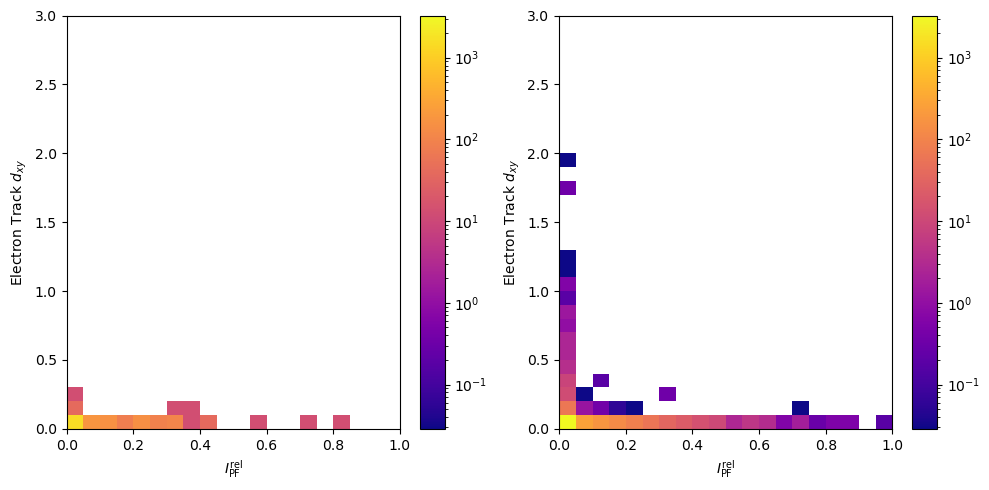

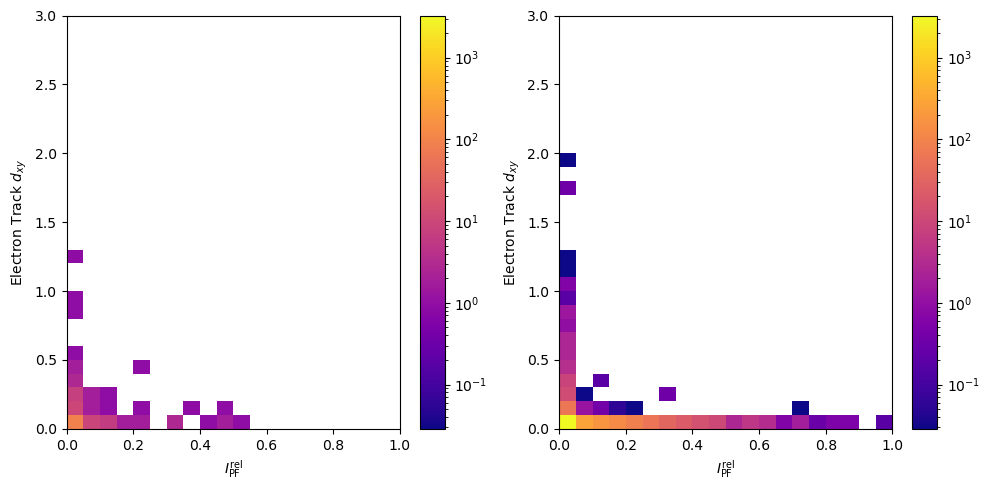

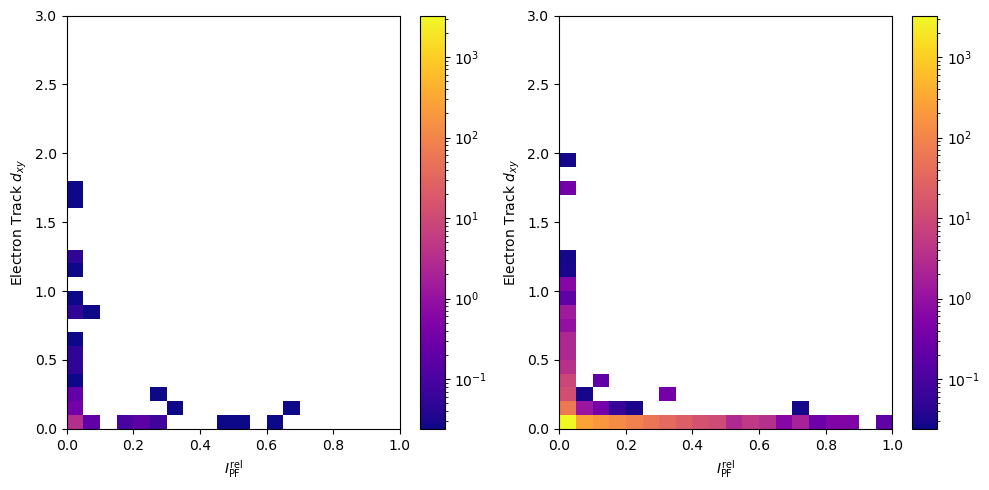

In [10]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_maxPFIso_vs_mindxy",1j,1j,xlim=[0,1],ylim=[0,3])

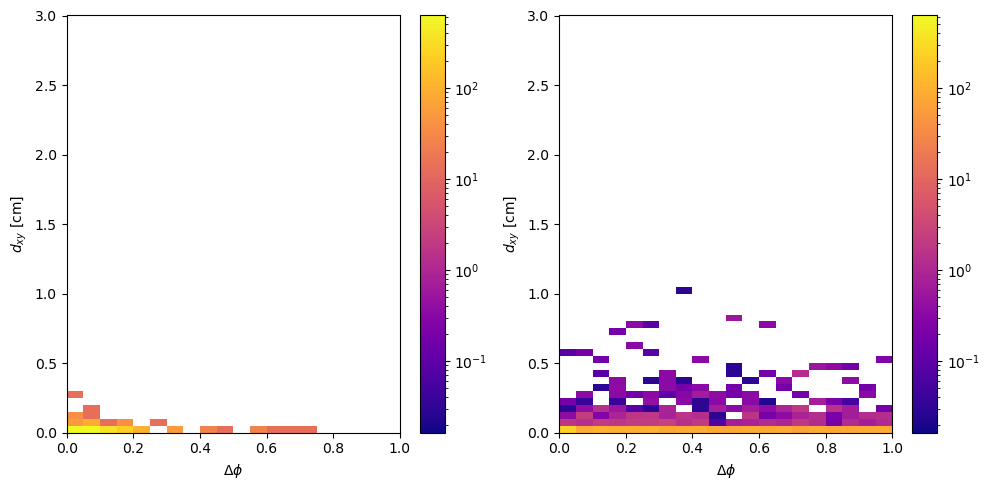

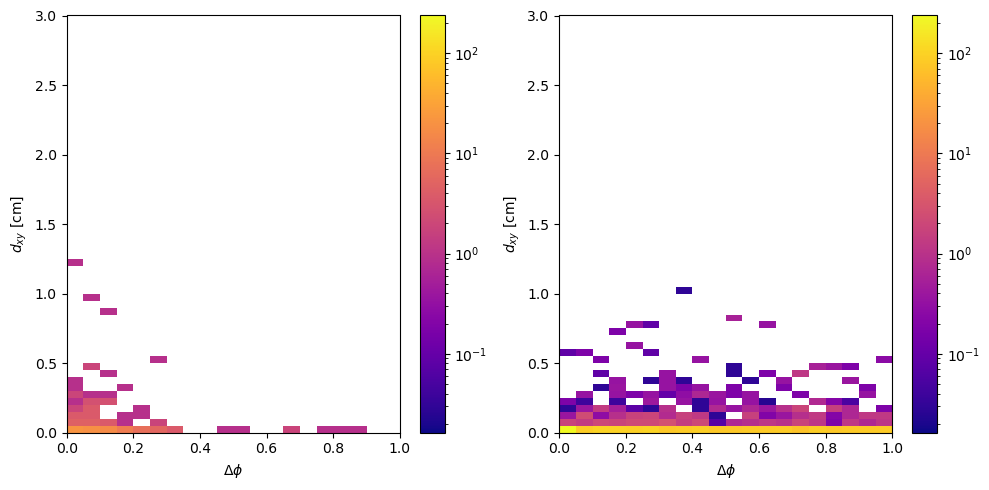

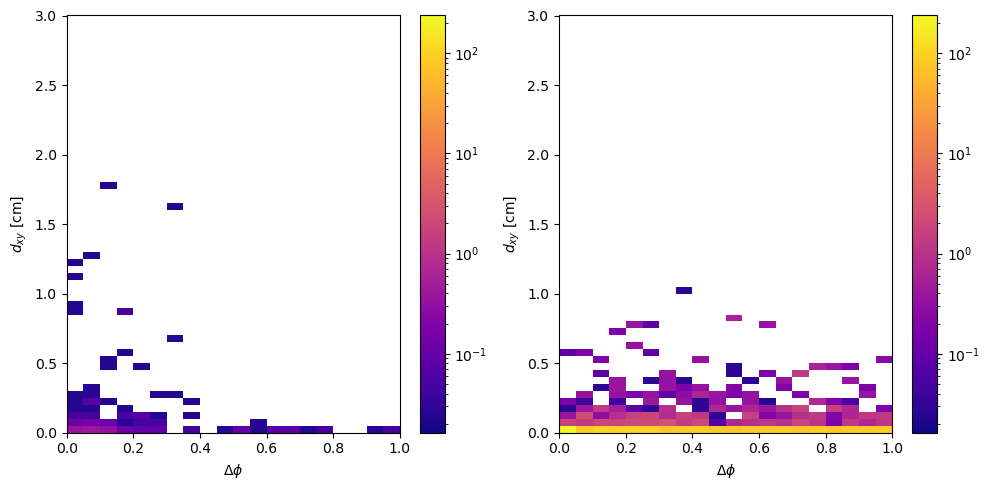

In [11]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_METdPhi_vs_mindxy",1j,1j,xlim=[0,1],ylim=[0,3])

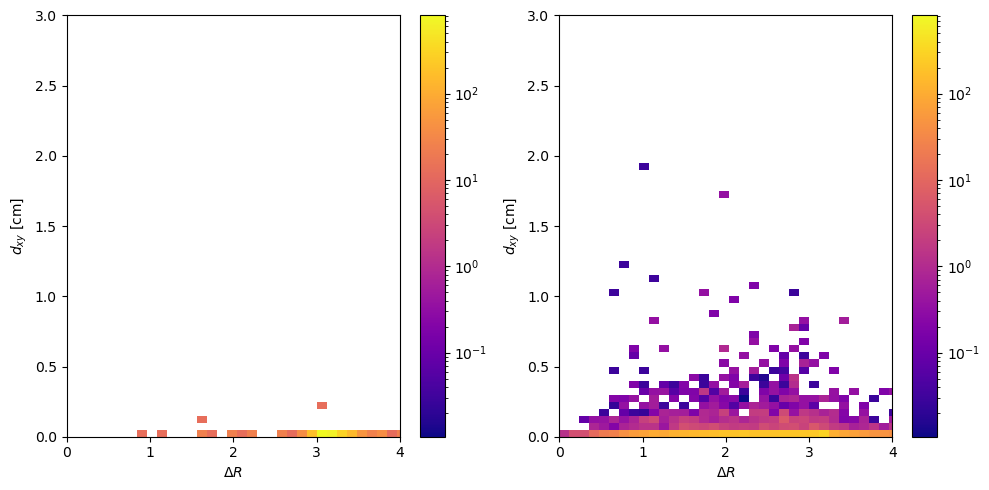

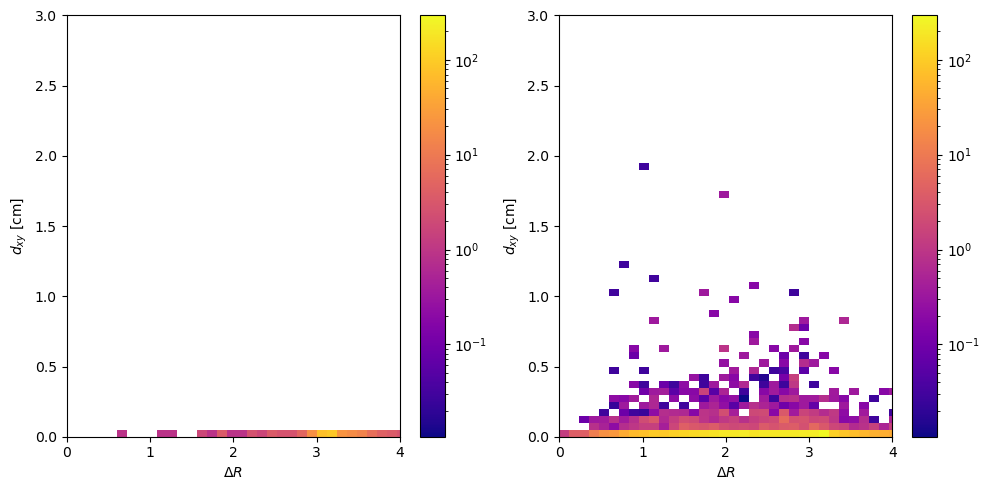

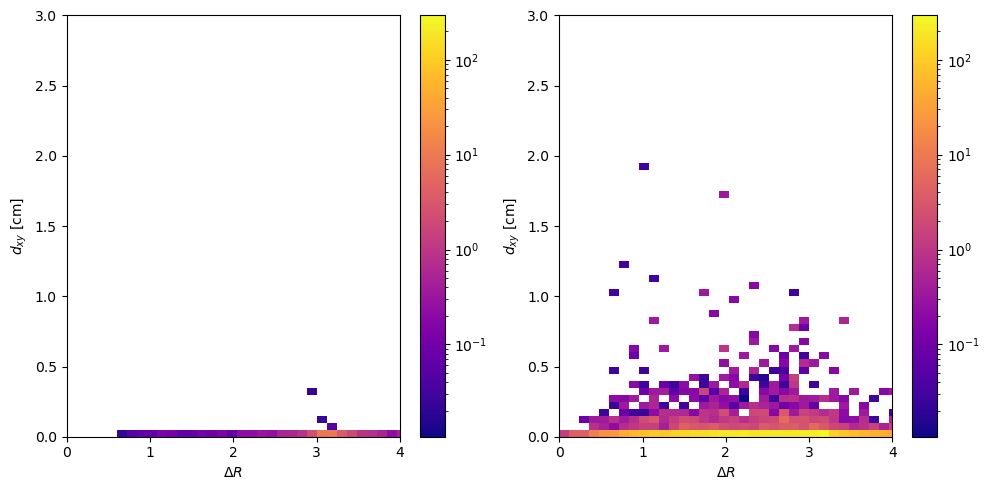

In [17]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_mindRj_vs_mindxy",2j,1j,xlim=[0,4],ylim=[0,3])

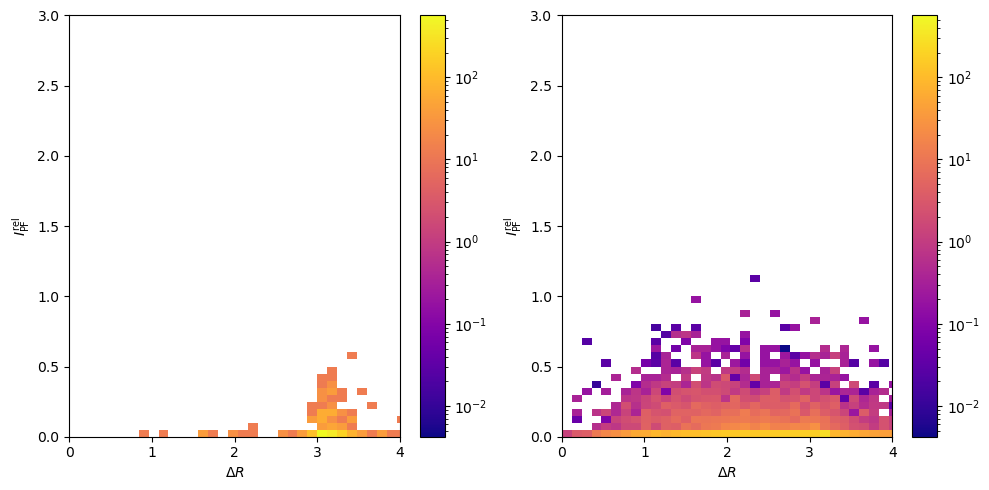

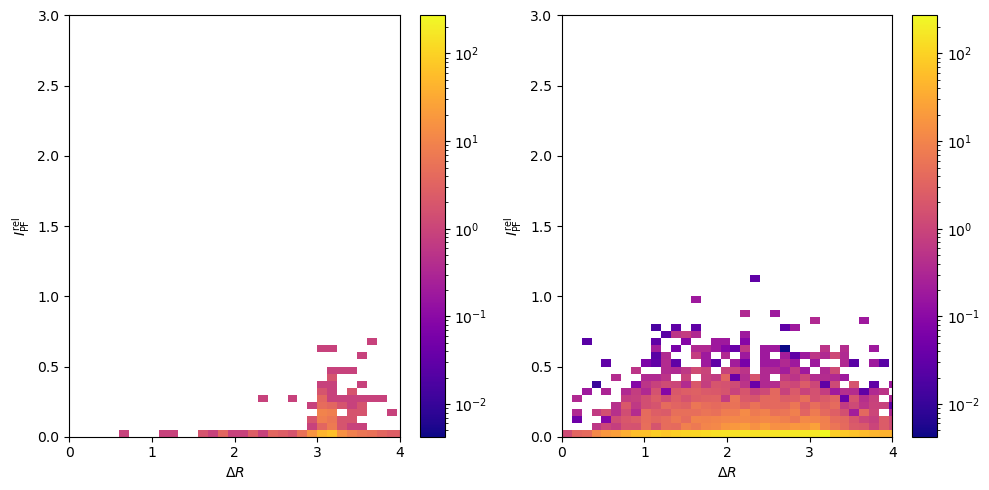

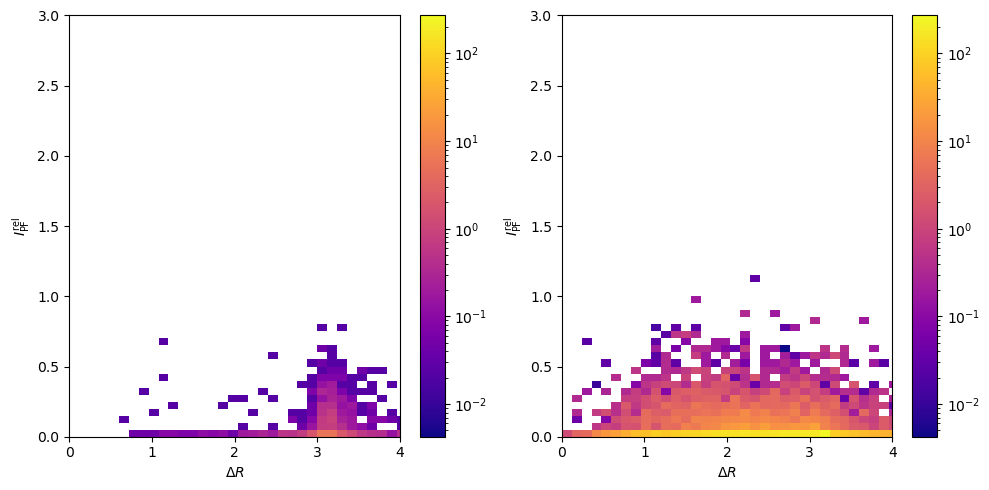

In [18]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_mindRj_vs_maxPFIso",2j,1j,xlim=[0,4],ylim=[0,3])

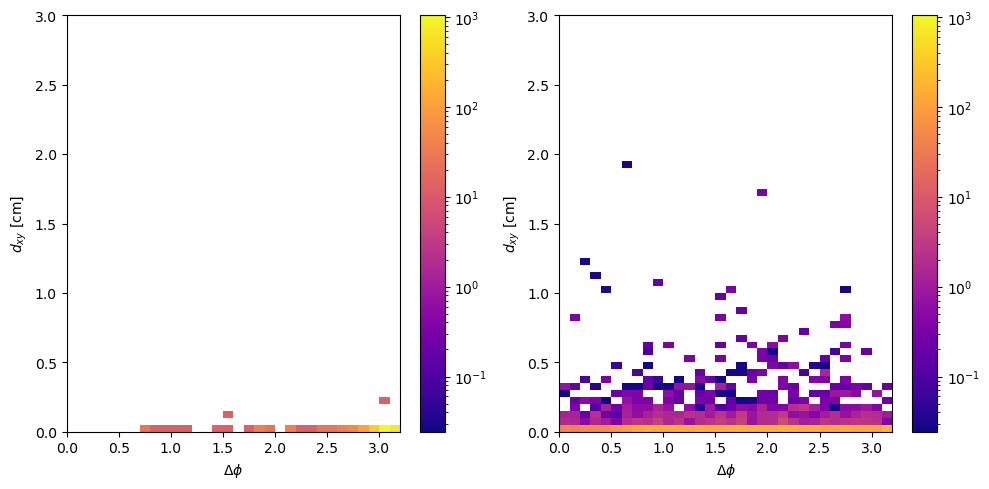

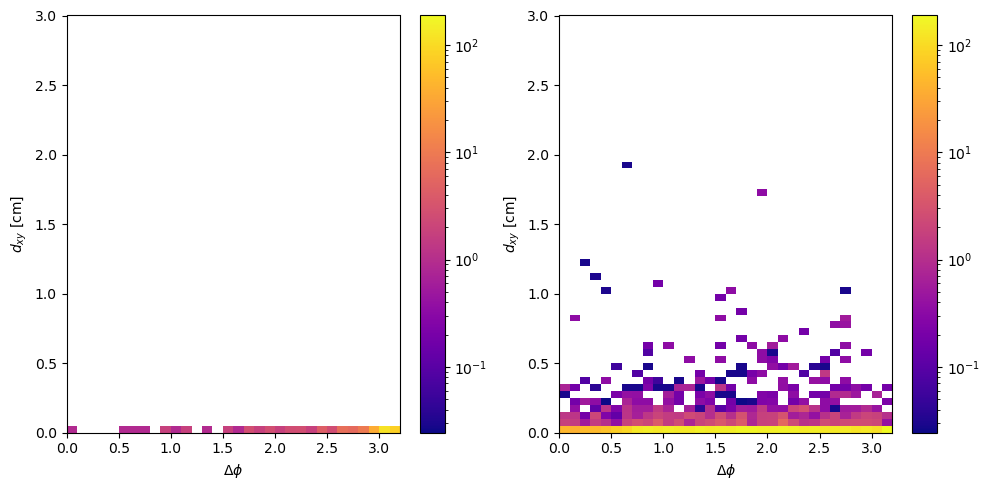

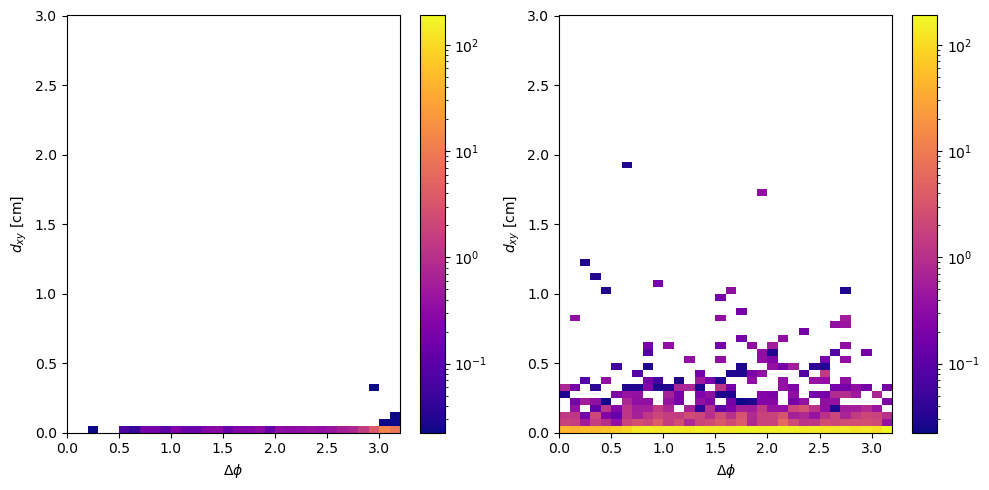

In [19]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_mindPhiJ_vs_mindxy",2j,1j,xlim=[0,3.2],ylim=[0,3])

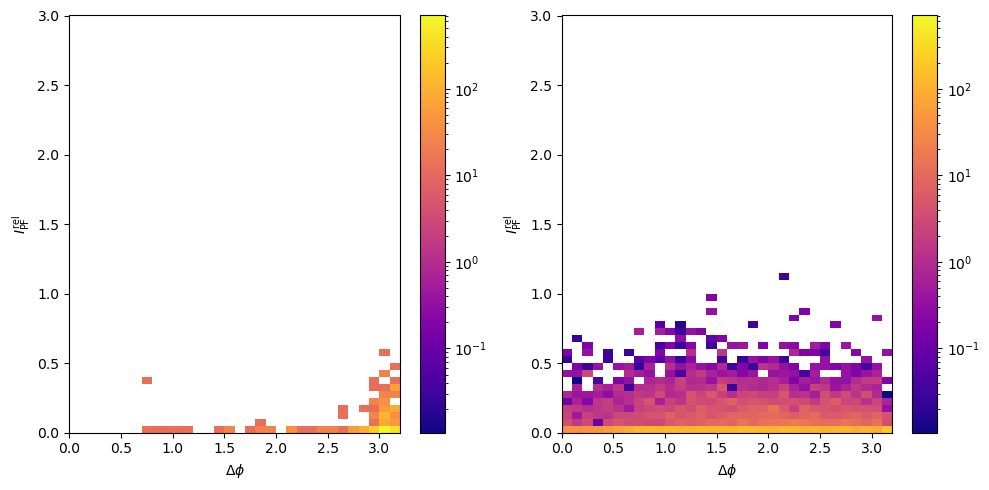

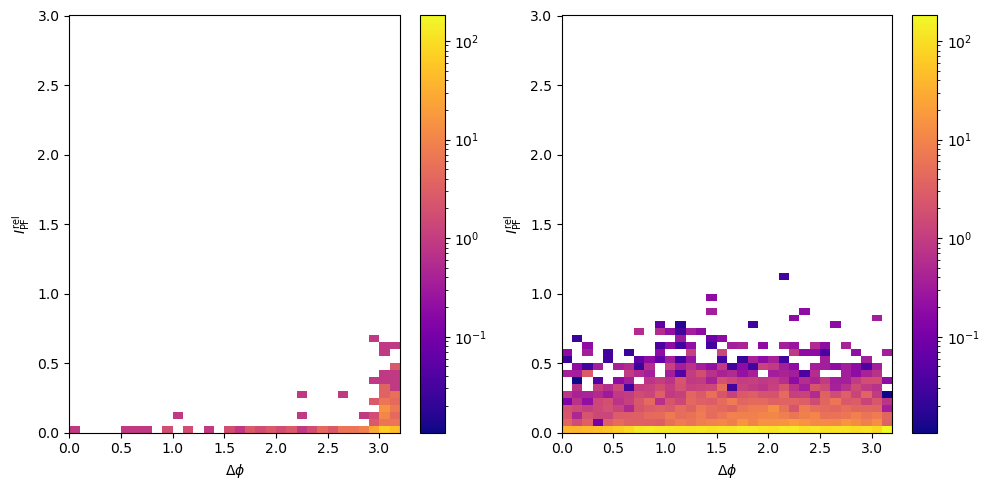

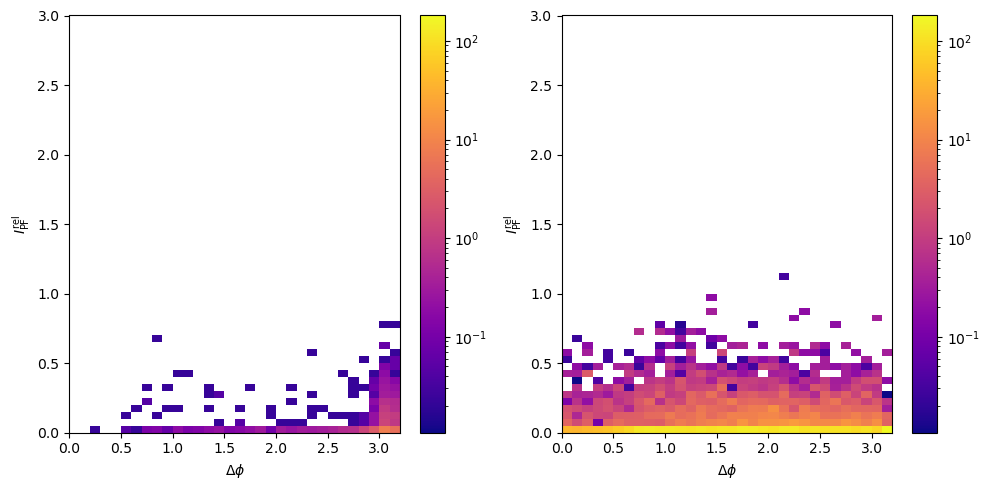

In [20]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_mindPhiJ_vs_maxPFIso",2j,1j,xlim=[0,3.2],ylim=[0,3])

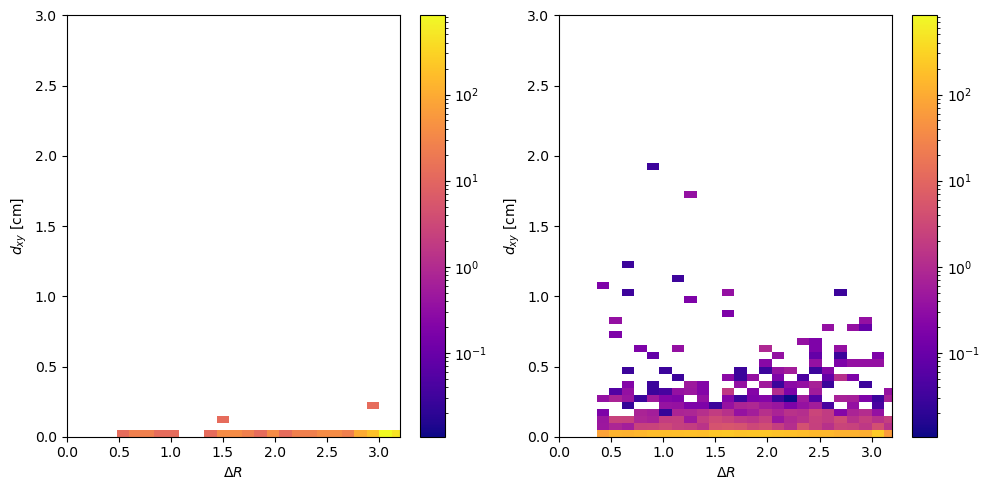

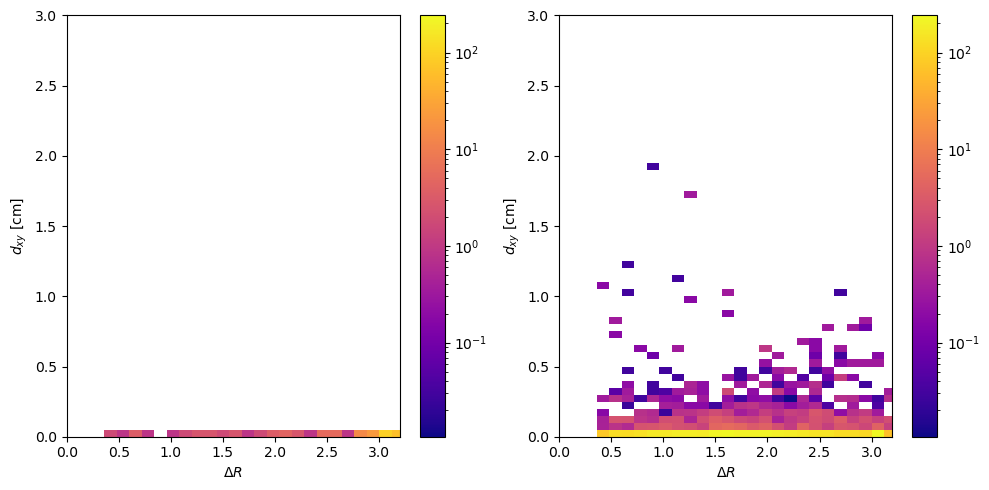

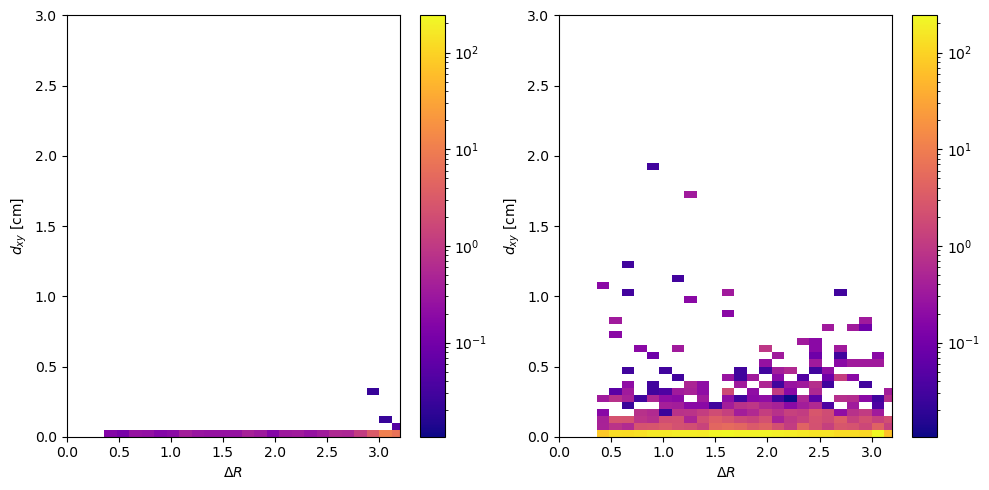

In [21]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_minEledRj_vs_mindxy",2j,1j,xlim=[0,3.2],ylim=[0,3])

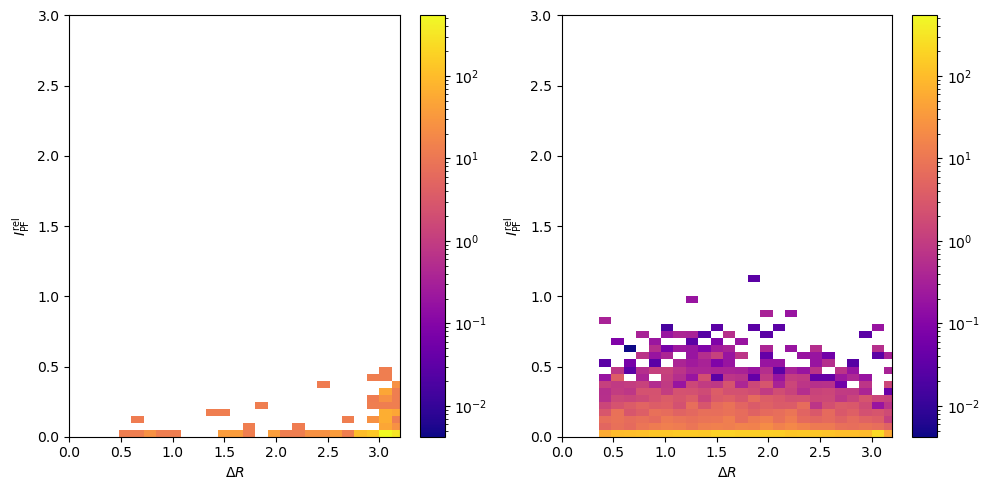

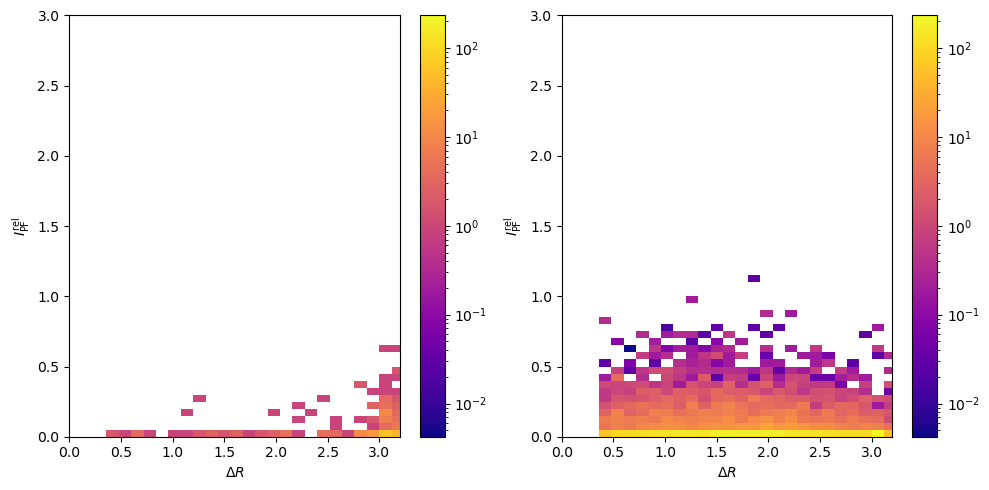

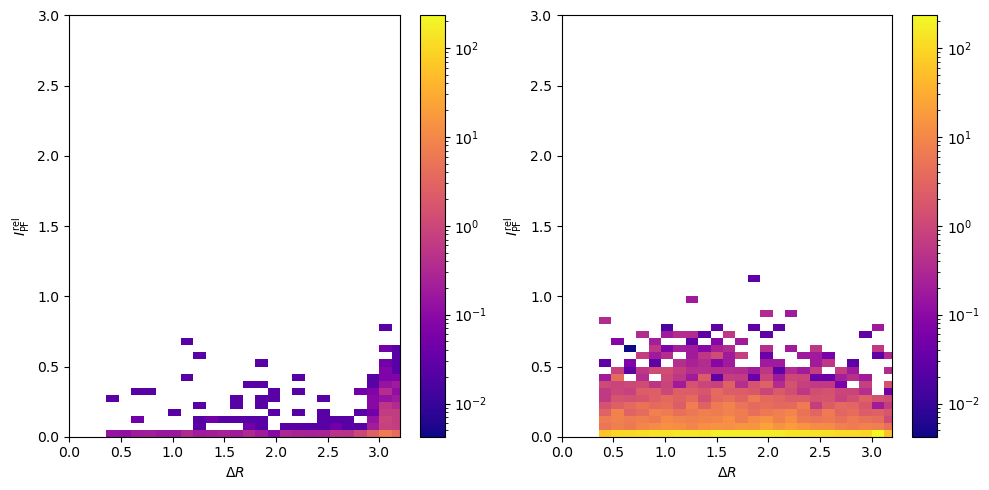

In [22]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_minEledRj_vs_maxPFIso",2j,1j,xlim=[0,3.2],ylim=[0,3])

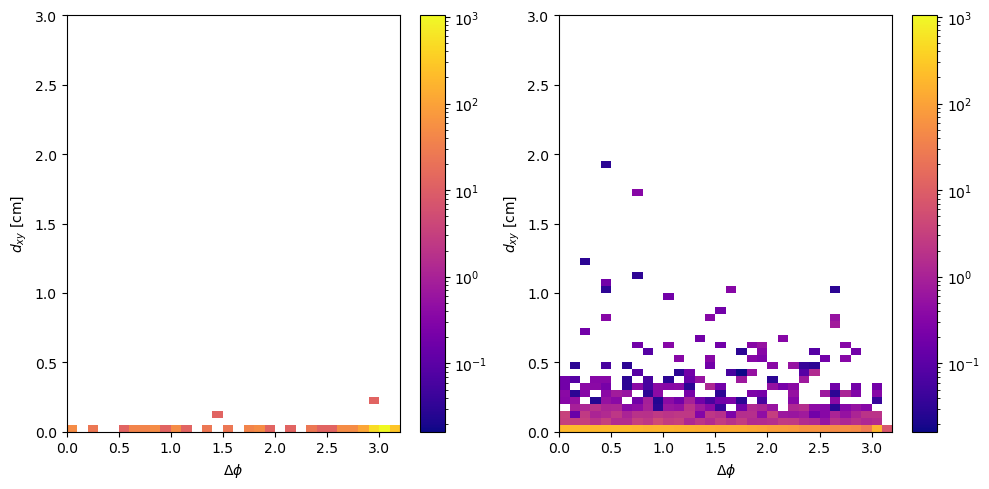

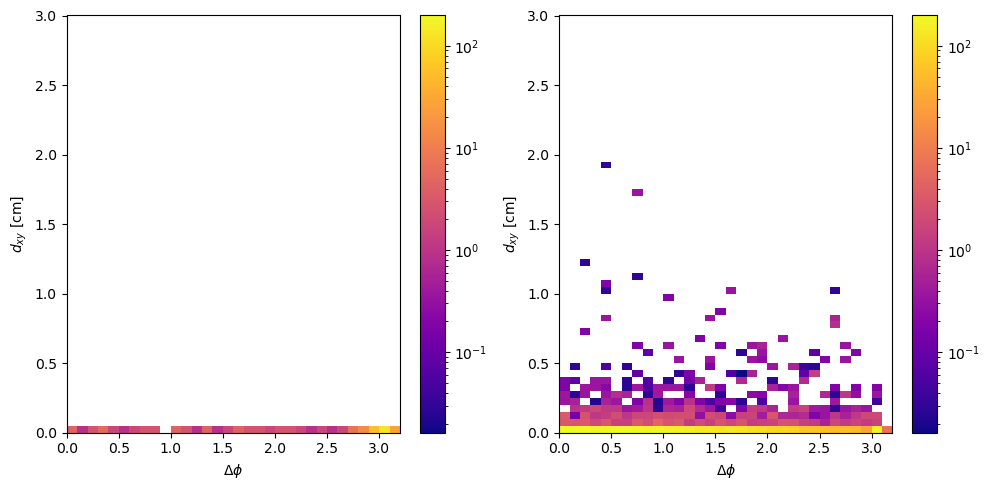

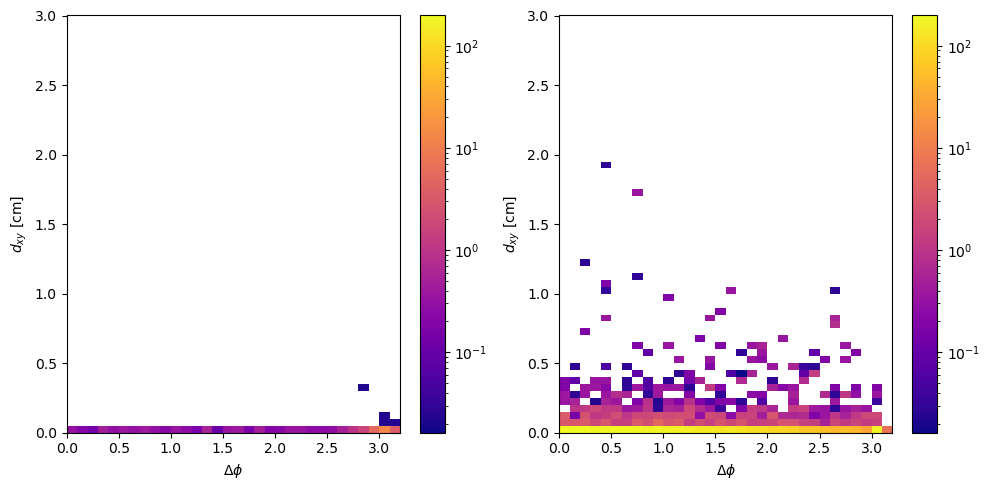

In [23]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_minEledPhiJ_vs_mindxy",2j,1j,xlim=[0,3.2],ylim=[0,3])

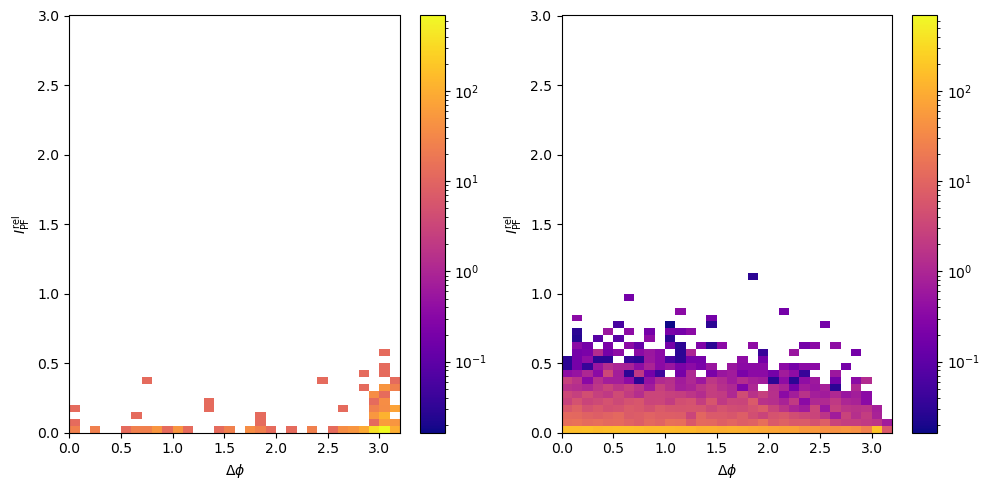

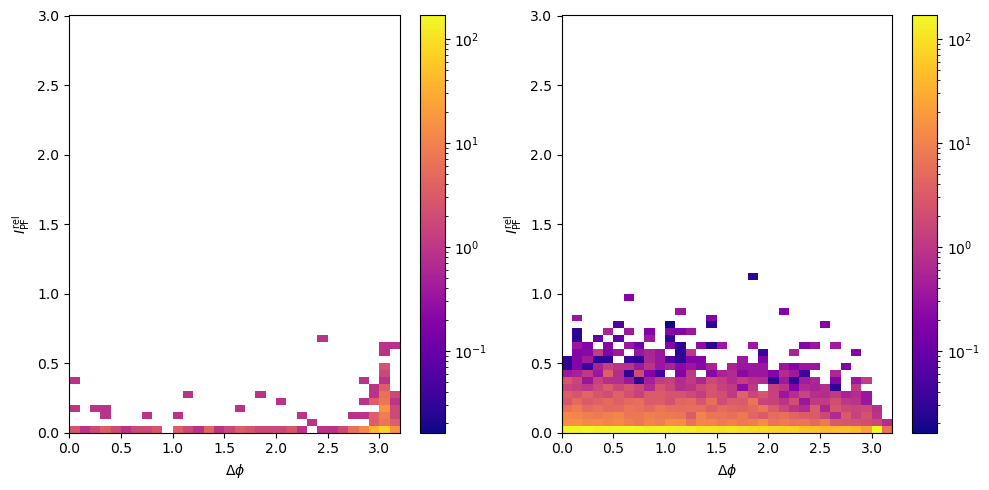

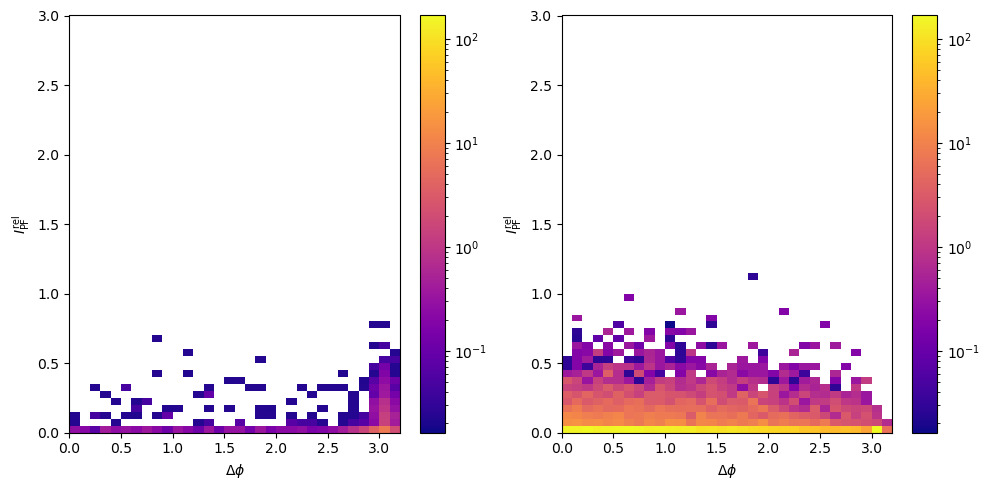

In [24]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_minEledPhiJ_vs_maxPFIso",2j,1j,xlim=[0,3.2],ylim=[0,3])

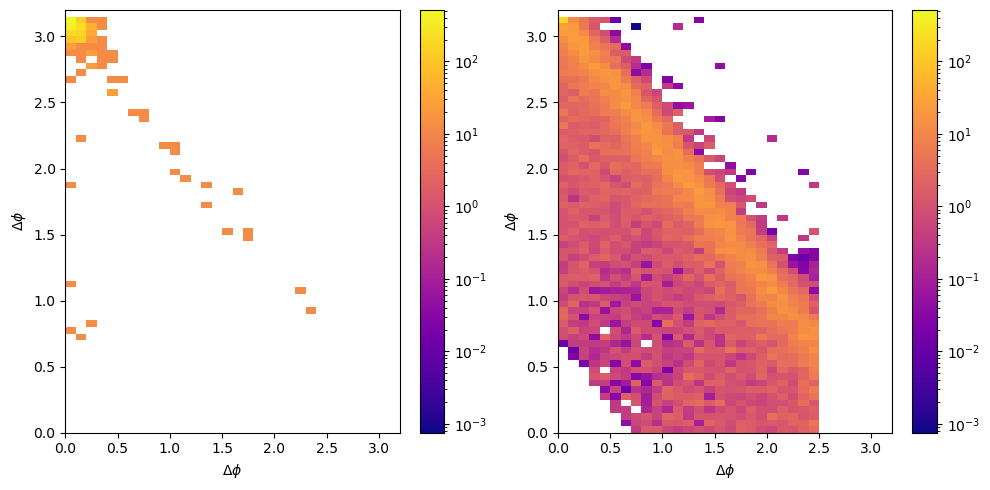

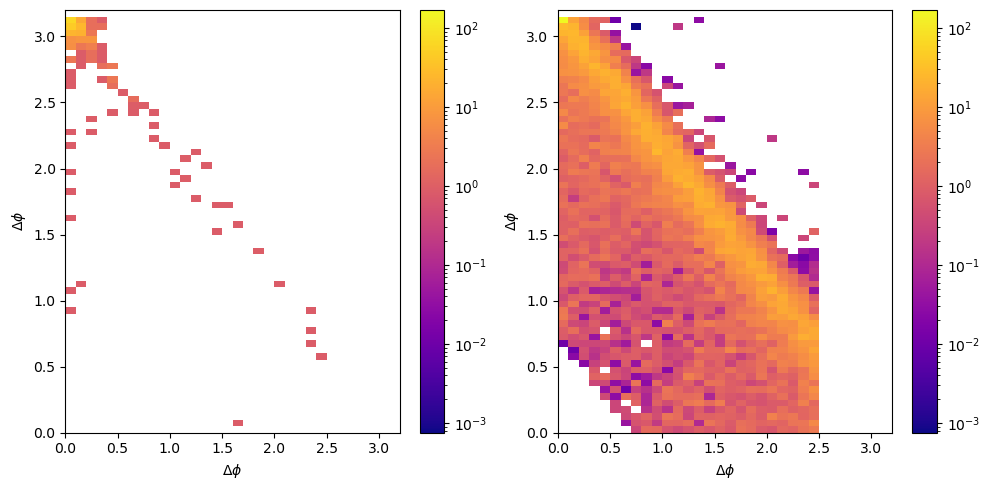

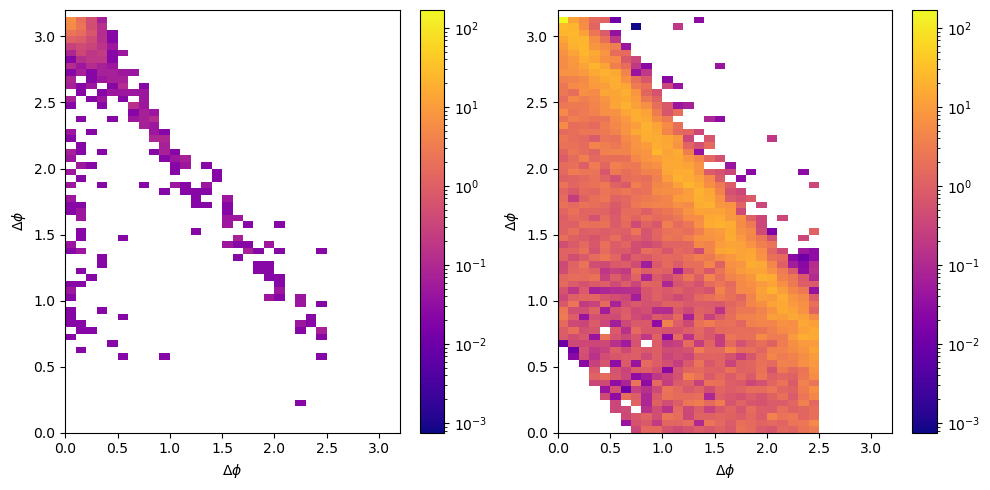

In [25]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_METdPhi_vs_mindPhiJ",2j,1j,xlim=[0,3.2],ylim=[0,3.2])

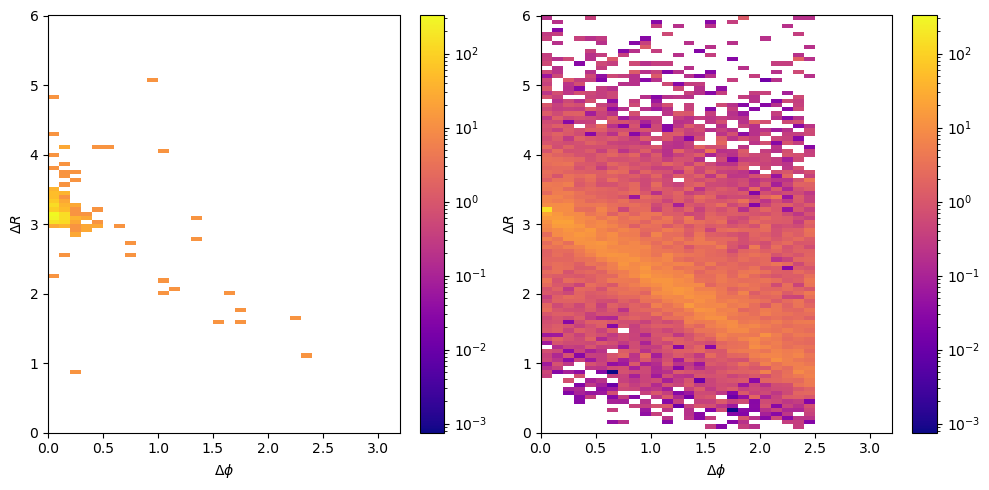

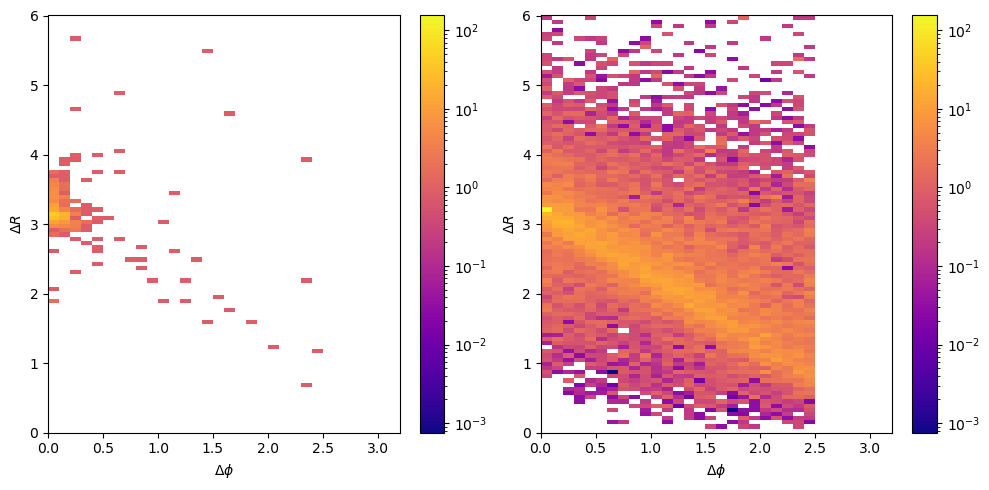

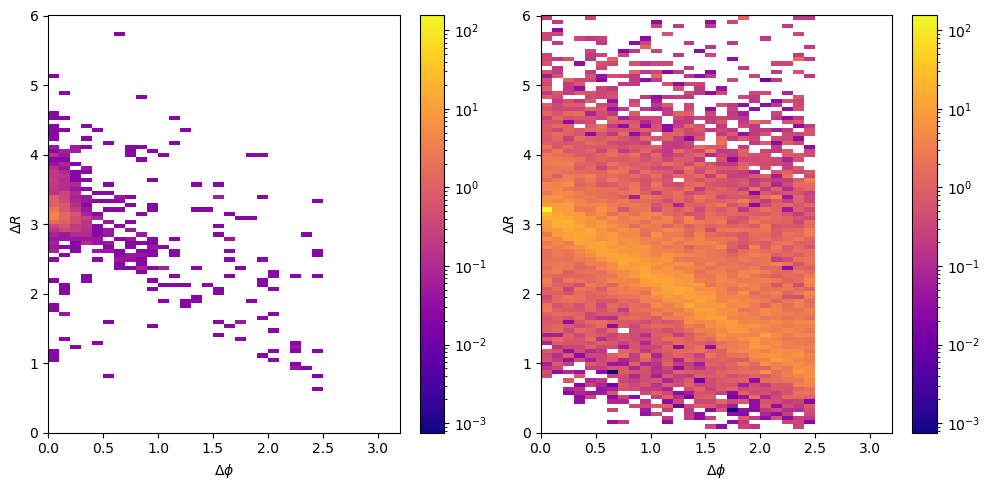

In [26]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_METdPhi_vs_mindRj",2j,1j,xlim=[0,3.2],ylim=[0,6])

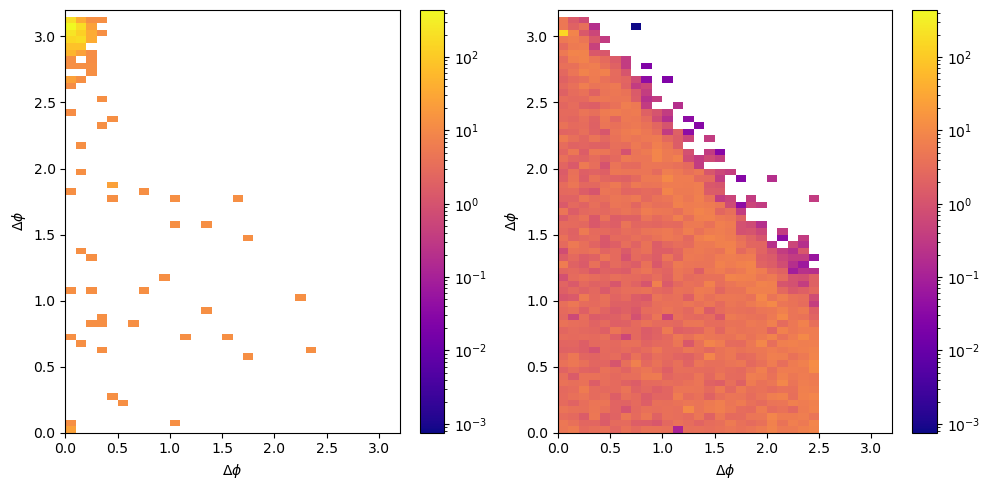

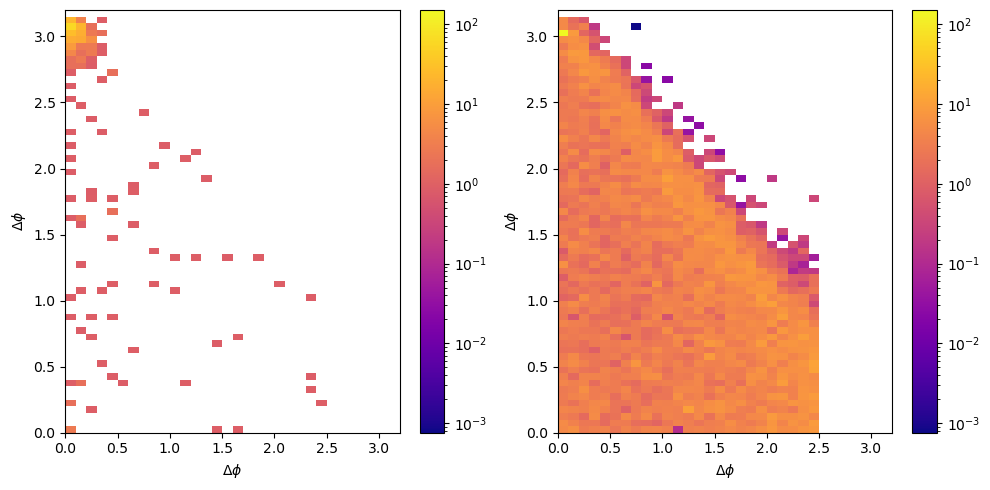

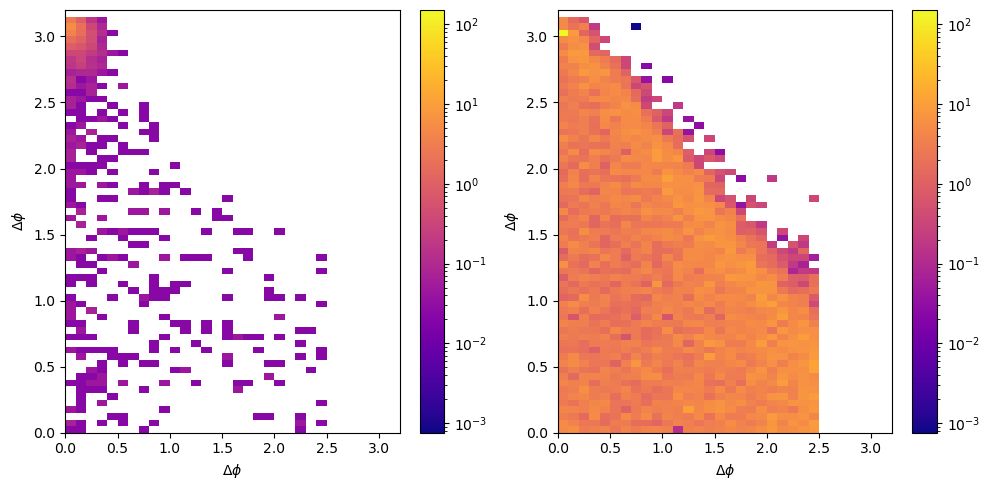

In [27]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_METdPhi_vs_minEledPhiJ",2j,1j,xlim=[0,3.2],ylim=[0,3.2])

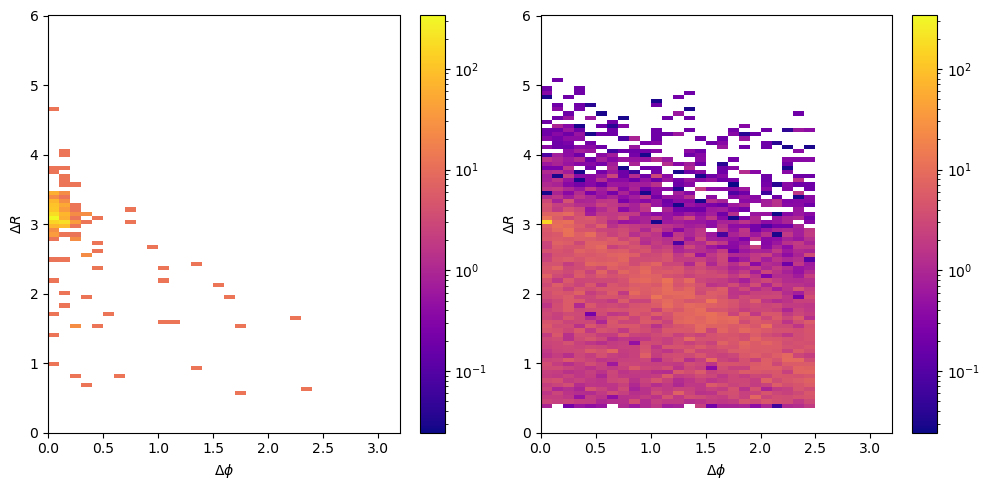

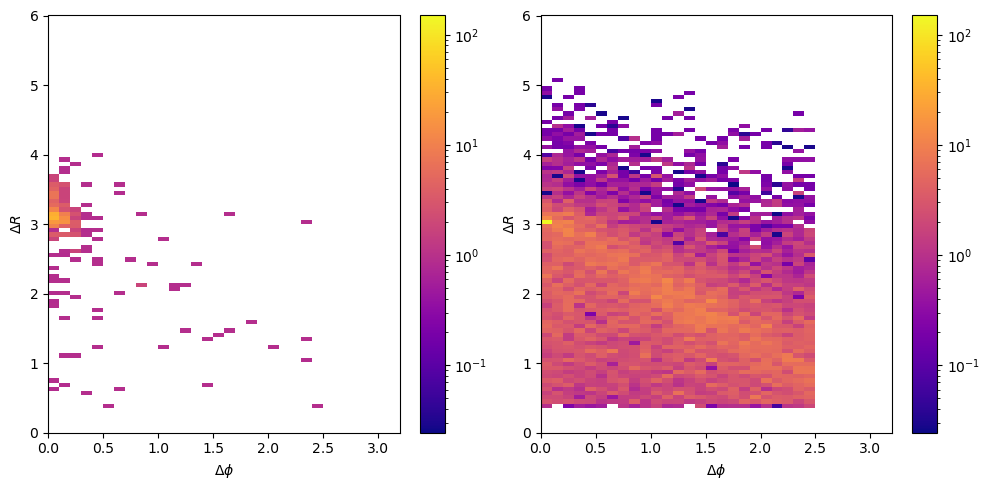

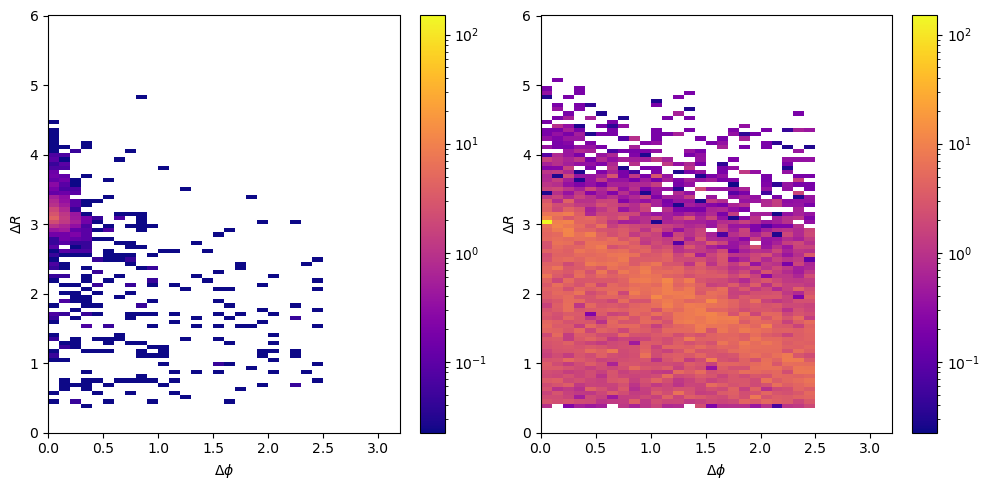

In [28]:
plot("sig_2018_Mchi-10p5_dMchi-1p0","sel_vtx_METdPhi_vs_minEledRj",2j,1j,xlim=[0,3.2],ylim=[0,6])